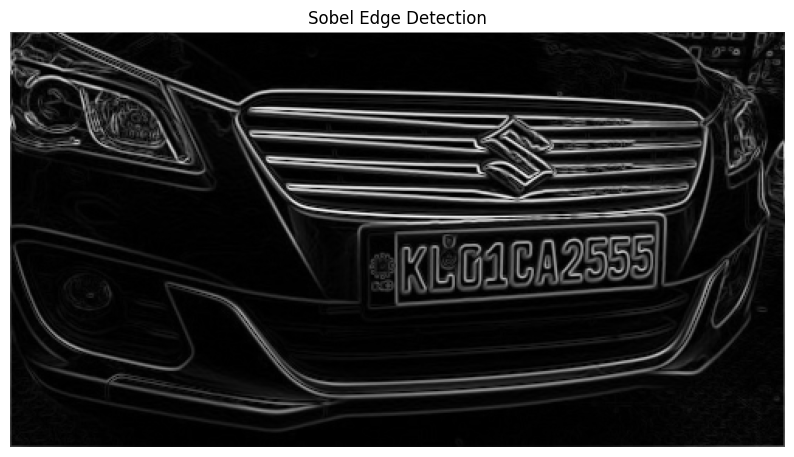

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('dataset/Cars0.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def convolution(image, kernel):
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape
    
    pad_height = kernel_h // 2
    pad_width = kernel_w // 2
    
    output = np.zeros_like(image, dtype=float)
    
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    
    for i in range(image_h):
        for j in range(image_w):
            region = padded_image[i:i+kernel_h, j:j+kernel_w]
            output[i, j] = np.sum(region * kernel)
    
    return output

def sobel_edge_detection(image):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    gradient_x = convolution(image, sobel_x)
    gradient_y = convolution(image, sobel_y)

    magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    angle = np.arctan2(gradient_y, gradient_x) * (180.0 / np.pi)

    return magnitude, angle

plt.figure(figsize=(10, 10))
plt.imshow(sobel_edge_detection(gray)[0], cmap='gray')
plt.title('Sobel Edge Detection')
plt.axis('off')
plt.show()

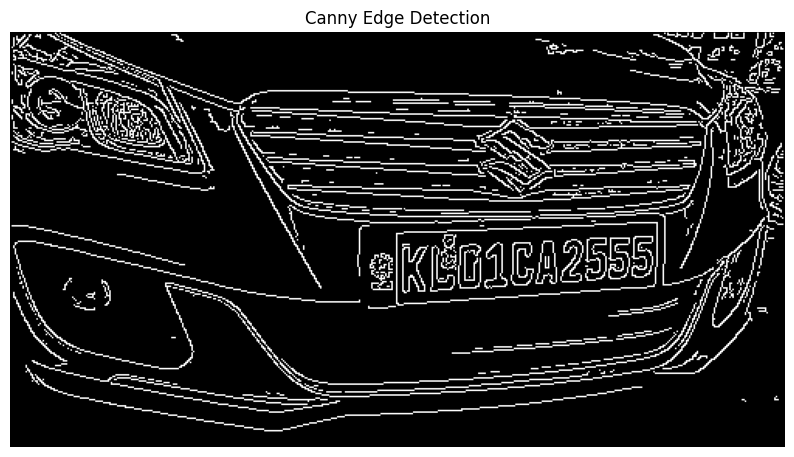

In [5]:
def non_maximum_suppression(magnitude, angle):
    image_h, image_w = magnitude.shape
    
    suppressed = np.zeros_like(magnitude)
    
    for i in range(1, image_h - 1):
        for j in range(1, image_w - 1):
            theta = angle[i, j]
            
            if (0 <= theta < 22.5) or (157.5 <= theta <= 180) or (-22.5 <= theta < 0) or (-180 <= theta < -157.5):
                neighbors = [magnitude[i, j-1], magnitude[i, j+1]]
            elif (22.5 <= theta < 67.5) or (-157.5 <= theta < -112.5):
                neighbors = [magnitude[i-1, j-1], magnitude[i+1, j+1]]
            elif (67.5 <= theta < 112.5) or (-112.5 <= theta < -67.5):
                neighbors = [magnitude[i-1, j], magnitude[i+1, j]]
            else:
                neighbors = [magnitude[i-1, j+1], magnitude[i+1, j-1]]
            
            if magnitude[i, j] >= max(neighbors):
                suppressed[i, j] = magnitude[i, j]
    
    return suppressed

def thresholding(magnitude, low_threshold_ratio=0.05, high_threshold_ratio=0.09):
    high_threshold = magnitude.max() * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio
    
    result = np.zeros_like(magnitude)
    
    weak = 25
    strong = 255
    result[magnitude >= high_threshold] = strong
    result[(magnitude >= low_threshold) & (magnitude < high_threshold)] = weak
    
    return result

def hysteresis_thresholding(image, weak, strong):
    image_height, image_width = image.shape
    
    result = np.zeros_like(image)
    
    for i in range(1, image_height - 1):
        for j in range(1, image_width - 1):
            if image[i, j] == weak:
                if (strong in [image[i-1, j-1], image[i-1, j], image[i-1, j+1],
                               image[i, j-1], image[i, j+1],
                               image[i+1, j-1], image[i+1, j], image[i+1, j+1]]):
                    result[i, j] = strong
                else:
                    result[i, j] = 0
            elif image[i, j] == strong:
                result[i, j] = strong
    
    return result

def canny_edge_detection(image):
    magnitude, angle = sobel_edge_detection(image)
    
    suppressed = non_maximum_suppression(magnitude, angle)
    
    thresholded = thresholding(suppressed)
    
    edge_map = hysteresis_thresholding(thresholded, 25, 255)
    
    return edge_map


edges = canny_edge_detection(gray)
plt.figure(figsize=(10, 10))
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')
plt.show()

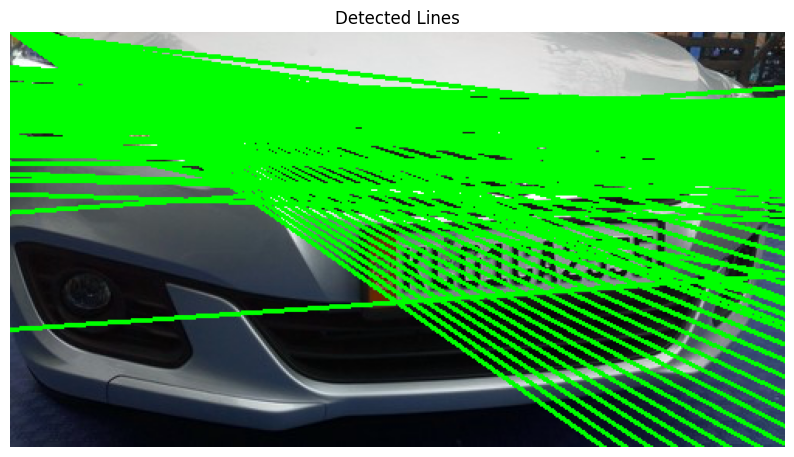

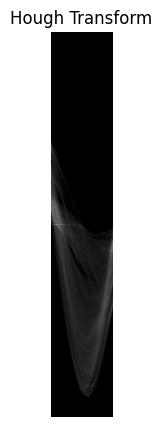

In [6]:
def hough_transform(image, threshold):
    height, width = image.shape
    max_rho = int(np.sqrt(height**2 + width**2))
    num_thetas = 180
    hough_space = np.zeros((max_rho * 2, num_thetas), dtype=np.uint64)

    thetas = np.deg2rad(np.arange(-90, 90))

    edge_pixels = np.nonzero(image)

    for i in range(len(edge_pixels[0])):
        y = edge_pixels[0][i]
        x = edge_pixels[1][i]
        for theta_index in range(num_thetas):
            theta = thetas[theta_index]
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            hough_space[rho + max_rho, theta_index] += 1

    hough_space[hough_space < threshold] = 0

    return hough_space


def draw_lines(image, hough_space, num_lines):
    indices = np.argpartition(hough_space.flatten(), -num_lines)[-num_lines:]
    rho_indices, theta_indices = np.unravel_index(indices, hough_space.shape)

    max_rho = hough_space.shape[0] // 2
    thetas = np.deg2rad(np.arange(-90, 90))
    rhos = np.arange(-max_rho, max_rho)
    rhos = rhos[rho_indices]
    thetas = thetas[theta_indices]

    lines_image = np.copy(image)
    for rho, theta in zip(rhos, thetas):
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        x0 = rho * cos_theta
        y0 = rho * sin_theta
        x1 = int(x0 + 1000 * (-sin_theta))
        y1 = int(y0 + 1000 * (cos_theta))
        x2 = int(x0 - 1000 * (-sin_theta))
        y2 = int(y0 - 1000 * (cos_theta))
        cv2.line(lines_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return lines_image

hough_space = hough_transform(edges, threshold=15)

lines_image = draw_lines(image, hough_space, num_lines=100)

plt.figure(figsize=(10, 10))
plt.imshow(lines_image)
plt.title('Detected Lines')
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(hough_space, cmap='gray')
plt.title('Hough Transform')
plt.axis('off')
plt.show()
